In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from sklearn.datasets import load_iris, make_blobs, fetch_california_housing
import pandas as pd
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator, ClusteringEvaluator

In [ ]:
# Membuat sesi Spark
spark = SparkSession.builder.appName("PertemuanKeLupaGatauBerapa").getOrCreate()

# Regresi

In [ ]:
# Load dataset
california = fetch_california_housing()
california_df = pd.DataFrame(california.data, columns=california.feature_names)
california_df["target"] = california.target

In [ ]:
# Convert ke PySpark DataFrame
spark_california_df = spark.createDataFrame(california_df)

In [ ]:
spark_california_df.show(15)

+------+--------+------------------+------------------+----------+------------------+--------+---------+------+
|MedInc|HouseAge|          AveRooms|         AveBedrms|Population|          AveOccup|Latitude|Longitude|target|
+------+--------+------------------+------------------+----------+------------------+--------+---------+------+
|8.3252|    41.0| 6.984126984126984|1.0238095238095237|     322.0|2.5555555555555554|   37.88|  -122.23| 4.526|
|8.3014|    21.0| 6.238137082601054|0.9718804920913884|    2401.0| 2.109841827768014|   37.86|  -122.22| 3.585|
|7.2574|    52.0| 8.288135593220339| 1.073446327683616|     496.0|2.8022598870056497|   37.85|  -122.24| 3.521|
|5.6431|    52.0|5.8173515981735155|1.0730593607305936|     558.0| 2.547945205479452|   37.85|  -122.25| 3.413|
|3.8462|    52.0| 6.281853281853282|1.0810810810810811|     565.0|2.1814671814671813|   37.85|  -122.25| 3.422|
|4.0368|    52.0| 4.761658031088083|1.1036269430051813|     413.0| 2.139896373056995|   37.85|  -122.25|

In [ ]:
california_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [ ]:
spark_california_df.printSchema()

root
 |-- MedInc: double (nullable = true)
 |-- HouseAge: double (nullable = true)
 |-- AveRooms: double (nullable = true)
 |-- AveBedrms: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- AveOccup: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- target: double (nullable = true)



In [ ]:
spark_california_df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+
|summary|            MedInc|          HouseAge|          AveRooms|         AveBedrms|        Population|          AveOccup|          Latitude|          Longitude|            target|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+
|  count|             20640|             20640|             20640|             20640|             20640|             20640|             20640|              20640|             20640|
|   mean| 3.870671002906976|28.639486434108527| 5.428999742190385| 1.096675149606209|1425.4767441860465|3.0706551594363716|  35.6318614341086|-119.56970445736394|2.0685581690891293|
| stddev|1.8998217179452666|12.585557612111632|2.4741731394243245|0.4739108567954673|1132.

In [ ]:
# Preprocessing
assembler = VectorAssembler(inputCols=california.feature_names, outputCol="features")
spark_california_df = assembler.transform(spark_california_df).select("features", "target")

In [ ]:
spark_california_df.show(5)

+--------------------+------+
|            features|target|
+--------------------+------+
|[8.3252,41.0,6.98...| 4.526|
|[8.3014,21.0,6.23...| 3.585|
|[7.2574,52.0,8.28...| 3.521|
|[5.6431,52.0,5.81...| 3.413|
|[3.8462,52.0,6.28...| 3.422|
+--------------------+------+
only showing top 5 rows



In [ ]:
train, test = spark_california_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
lr = LinearRegression(featuresCol="features", labelCol="target")
lr_model = lr.fit(train)
predictions = lr_model.transform(test)
print("Prediksi Regresi:")
predictions.show()

Prediksi Regresi:
+--------------------+-------+--------------------+
|            features| target|          prediction|
+--------------------+-------+--------------------+
|[0.4999,28.0,7.67...|5.00001|  0.8636611002081835|
|[0.4999,52.0,2.6,...|  0.906|  1.0207615146533868|
|[0.536,16.0,4.5,1...|    3.5|   1.091494549716252|
|[0.6775,52.0,1.74...|    3.5|  1.5128374133887448|
|[0.7403,37.0,4.49...|  0.686|  1.1569189315147597|
|[0.76,10.0,2.6515...|  1.625|  1.0887481760842306|
|[0.8026,23.0,5.36...|  1.125|  0.9722254546464413|
|[0.8185,13.0,2.49...|  1.875|  0.9692636883896455|
|[0.8585,15.0,4.82...|   0.45| -0.1640116290411484|
|[0.8639,28.0,4.28...|  0.494|  0.7026276336935879|
|[0.8641,37.0,4.07...|  0.842|  1.2293545554076815|
|[0.8702,11.0,3.71...|  1.705|   0.794182512483097|
|[0.8907,34.0,2.28...|  1.542|  0.9605594770829953|
|[0.8964,24.0,5.72...|  0.592|-0.02265069454171...|
|[0.9234,40.0,2.73...|  1.875|  1.5398923505879978|
|[0.9337,45.0,4.71...|  0.923|  1.172024787496

In [ ]:
regressor_evaluator = RegressionEvaluator(labelCol="target",
                                          predictionCol="prediction",
                                          metricName="rmse")
rmse = regressor_evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")

r2_evaluator = RegressionEvaluator(labelCol="target",
                                   predictionCol="prediction",
                                   metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print(f"R2: {r2}")

RMSE: 0.733293906676871
R2: 0.5863933868971052


# Klasifikasi

In [ ]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df["target"] = iris.target

In [ ]:
# Convert ke PySpark DataFrame
spark_iris_df = spark.createDataFrame(iris_df)

In [ ]:
spark_iris_df.printSchema()

root
 |-- sepal length (cm): double (nullable = true)
 |-- sepal width (cm): double (nullable = true)
 |-- petal length (cm): double (nullable = true)
 |-- petal width (cm): double (nullable = true)
 |-- target: long (nullable = true)



In [ ]:
spark_iris_df.show(10)

+-----------------+----------------+-----------------+----------------+------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|target|
+-----------------+----------------+-----------------+----------------+------+
|              5.1|             3.5|              1.4|             0.2|     0|
|              4.9|             3.0|              1.4|             0.2|     0|
|              4.7|             3.2|              1.3|             0.2|     0|
|              4.6|             3.1|              1.5|             0.2|     0|
|              5.0|             3.6|              1.4|             0.2|     0|
|              5.4|             3.9|              1.7|             0.4|     0|
|              4.6|             3.4|              1.4|             0.3|     0|
|              5.0|             3.4|              1.5|             0.2|     0|
|              4.4|             2.9|              1.4|             0.2|     0|
|              4.9|             3.1|              1.

In [ ]:
spark_iris_df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary| sepal length (cm)|  sepal width (cm)| petal length (cm)|  petal width (cm)|            target|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|               150|               150|               150|               150|               150|
|   mean| 5.843333333333332|3.0573333333333337| 3.758000000000001|1.1993333333333331|               1.0|
| stddev|0.8280661279778628|0.4358662849366982|1.7652982332594664|0.7622376689603467|0.8192319205190403|
|    min|               4.3|               2.0|               1.0|               0.1|                 0|
|    max|               7.9|               4.4|               6.9|               2.5|                 2|
+-------+------------------+------------------+------------------+------------------+------------------+



In [ ]:
assembler = VectorAssembler(inputCols=iris.feature_names, outputCol="features")
spark_iris_df = assembler.transform(spark_iris_df).select("features", "target")

In [ ]:
spark_iris_df.show()

+-----------------+------+
|         features|target|
+-----------------+------+
|[5.1,3.5,1.4,0.2]|     0|
|[4.9,3.0,1.4,0.2]|     0|
|[4.7,3.2,1.3,0.2]|     0|
|[4.6,3.1,1.5,0.2]|     0|
|[5.0,3.6,1.4,0.2]|     0|
|[5.4,3.9,1.7,0.4]|     0|
|[4.6,3.4,1.4,0.3]|     0|
|[5.0,3.4,1.5,0.2]|     0|
|[4.4,2.9,1.4,0.2]|     0|
|[4.9,3.1,1.5,0.1]|     0|
|[5.4,3.7,1.5,0.2]|     0|
|[4.8,3.4,1.6,0.2]|     0|
|[4.8,3.0,1.4,0.1]|     0|
|[4.3,3.0,1.1,0.1]|     0|
|[5.8,4.0,1.2,0.2]|     0|
|[5.7,4.4,1.5,0.4]|     0|
|[5.4,3.9,1.3,0.4]|     0|
|[5.1,3.5,1.4,0.3]|     0|
|[5.7,3.8,1.7,0.3]|     0|
|[5.1,3.8,1.5,0.3]|     0|
+-----------------+------+
only showing top 20 rows



In [ ]:
# Split Data
train, test = spark_iris_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
lr = LogisticRegression(featuresCol="features", labelCol="target", maxIter=10)
lr_model = lr.fit(train)
predictions = lr_model.transform(test)
print("Prediksi Klasifikasi:")
predictions.show()

Prediksi Klasifikasi:
+-----------------+------+--------------------+--------------------+----------+
|         features|target|       rawPrediction|         probability|prediction|
+-----------------+------+--------------------+--------------------+----------+
|[4.4,3.0,1.3,0.2]|     0|[18.4881102722326...|[0.99997956637236...|       0.0|
|[4.6,3.2,1.4,0.2]|     0|[18.6731364276534...|[0.99997845923892...|       0.0|
|[4.6,3.6,1.0,0.2]|     0|[22.5439678867162...|[0.99999953371617...|       0.0|
|[4.8,3.1,1.6,0.2]|     0|[16.5922527329727...|[0.99974667589489...|       0.0|
|[4.9,3.1,1.5,0.2]|     0|[16.5135751261617...|[0.99961967633528...|       0.0|
|[5.0,3.2,1.2,0.2]|     0|[17.7212122562142...|[0.99982614479709...|       0.0|
|[5.0,3.6,1.4,0.2]|     0|[19.6804024826906...|[0.99998492590785...|       0.0|
|[5.1,3.8,1.5,0.3]|     0|[19.5765019043532...|[0.99998680030949...|       0.0|
|[5.4,3.7,1.5,0.2]|     0|[18.4217586876262...|[0.99988230608514...|       0.0|
|[5.4,3.9,1.3,0.4]

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Akurasi: {accuracy}")

Akurasi: 1.0


# Clustering

In [ ]:
# Load dataset
X, _ = make_blobs(n_samples=300, centers=3, cluster_std=1, random_state=42)
blobs_df = pd.DataFrame(X, columns=["Feature1", "Feature2"])

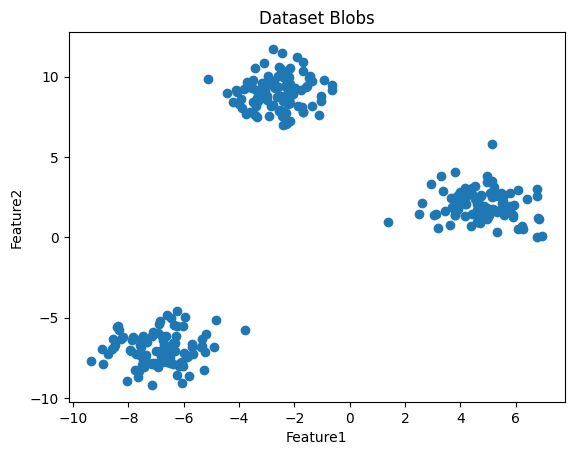

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(blobs_df["Feature1"], blobs_df["Feature2"])
plt.xlabel("Feature1")
plt.ylabel("Feature2")
plt.title("Dataset Blobs")
plt.show()

In [ ]:
# Convert ke PySpark DataFrame
spark_blobs_df = spark.createDataFrame(blobs_df)

In [ ]:
spark_blobs_df.printSchema()

root
 |-- Feature1: double (nullable = true)
 |-- Feature2: double (nullable = true)



In [ ]:
spark_blobs_df.describe().show()

+-------+-------------------+------------------+
|summary|           Feature1|          Feature2|
+-------+-------------------+------------------+
|  count|                300|               300|
|   mean|-1.5900003646034588| 1.356726636034251|
| stddev|   4.91128429549514|6.6418786697912875|
|    min| -9.351271691278559|-9.182030758011532|
|    max|   6.95453740290161| 11.73445529478794|
+-------+-------------------+------------------+



In [ ]:
assembler = VectorAssembler(inputCols=["Feature1", "Feature2"], outputCol="features")
spark_blobs_df = assembler.transform(spark_blobs_df).select("features")

In [ ]:
kmeans = KMeans(featuresCol="features", k=3, seed=42)
kmeans_model = kmeans.fit(spark_blobs_df)
predictions = kmeans_model.transform(spark_blobs_df)
print("Prediksi Clustering:")
predictions.show()

Prediksi Clustering:
+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-7.3389880906915...|         1|
|[-7.7400405564352...|         1|
|[-1.6866527109495...|         2|
|[4.42219763300088...|         0|
|[-8.9177517263291...|         1|
|[5.49753845943012...|         0|
|[-2.3360166972015...|         2|
|[5.05281029050372...|         0|
|[-2.9883718608980...|         2|
|[-3.7005011202553...|         2|
|[-3.1109042352821...|         2|
|[4.99689432219314...|         0|
|[-2.3003340280479...|         2|
|[-3.9245683651031...|         2|
|[-7.5302697602730...|         1|
|[-3.2112507169301...|         2|
|[-8.5071696290344...|         1|
|[2.61473624957049...|         0|
|[-2.4121200737047...|         2|
|[-1.9223405292524...|         2|
+--------------------+----------+
only showing top 20 rows



In [ ]:
print("Pusat Cluster:")
for i, center in enumerate(kmeans_model.clusterCenters()):
    print(f"Cluster {i}: {center}")

Pusat Cluster:
Cluster 0: [4.74710337 2.01059427]
Cluster 1: [-6.88387179 -6.98398415]
Cluster 2: [-2.63323268  9.04356978]


In [ ]:
clustering_evaluator = ClusteringEvaluator(predictionCol="prediction", metricName="silhouette")
silhouette = clustering_evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette}")

Silhouette Score: 0.9696628776463792


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.stat import Correlation
from pyspark.sql.types import FloatType
from pyspark.ml.feature import Imputer
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

# Membuat sesi Spark
spark = SparkSession.builder.appName("ImbalancePreprocessing").getOrCreate()

# Contoh dataset dengan missing values dan imbalance
data = [
    (1, 2.0, 3.0, 0),
    (2, None, 2.5, 0),
    (3, 4.1, None, 1),
    (4, 3.5, 1.2, 0),
    (5, None, 0.5, 0),
    (6, 4.3, 2.1, 1),
    (7, 3.0, 3.3, 0),
    (8, 5.0, None, 0),
    (9, 2.1, 1.0, 0),
    (10, None, None, 1),
]
columns = ["ID", "Feature1", "Feature2", "Label"]

# Membuat DataFrame PySpark
df = spark.createDataFrame(data, columns)

# --- EDA ---
print("Data Awal:")
df.show()

# Cek missing values
print("Jumlah Missing Values per Kolom:")
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# --- Preprocessing ---
# 1. Mengatasi missing values dengan mean
imputer = Imputer(inputCols=["Feature1", "Feature2"], outputCols=["Feature1", "Feature2"])
df = imputer.fit(df).transform(df)

print("Data setelah imputasi missing values:")
df.show()

# 2. Menggabungkan fitur
assembler = VectorAssembler(inputCols=["Feature1", "Feature2"], outputCol="features")
df = assembler.transform(df).select("features", "Label")

# Convert ke Pandas untuk oversampling dengan SMOTE
df_pd = df.toPandas()

# 3. Mengatasi imbalance data menggunakan SMOTE
X = np.vstack(df_pd["features"].values)
y = df_pd["Label"].values
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert kembali ke PySpark DataFrame
resampled_data = [(list(X_resampled[i]), int(y_resampled[i])) for i in range(len(y_resampled))]
resampled_df = spark.createDataFrame(resampled_data, ["features", "Label"])

print("Data setelah SMOTE:")
resampled_df.show()

# 4. Standarisasi fitur
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(resampled_df)
scaled_df = scaler_model.transform(resampled_df)

print("Data setelah standarisasi:")
scaled_df.show()

# --- Modeling ---
# Logistic Regression
train, test = scaled_df.randomSplit([0.8, 0.2], seed=42)
lr = LogisticRegression(featuresCol="scaled_features", labelCol="Label", maxIter=10)
model = lr.fit(train)
predictions = model.transform(test)

print("Hasil Prediksi Logistic Regression:")
predictions.show()


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.stat import Correlation
from pyspark.sql.types import FloatType
from pyspark.ml.feature import Imputer
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

# Membuat sesi Spark
spark = SparkSession.builder.appName("TitanicProcessing").getOrCreate()

# Membaca dataset Titanic
file_path = "path_to_titanic.csv"  # Ganti dengan path dataset Titanic Anda
df = spark.read.csv(file_path, header=True, inferSchema=True)

# --- EDA ---
print("Skema Data:")
df.printSchema()

print("Contoh Data:")
df.show(5)

print("Jumlah Missing Values per Kolom:")
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# --- Preprocessing ---
# 1. Mengatasi missing values
imputer = Imputer(inputCols=["Age", "Fare"], outputCols=["Age", "Fare"])
df = imputer.fit(df).transform(df)

# Mengisi missing value kolom Embarked dengan modus
df = df.fillna({"Embarked": "S"})

# 2. Mengonversi kolom kategori ke numerik
indexer_sex = StringIndexer(inputCol="Sex", outputCol="Sex_Index")
indexer_embarked = StringIndexer(inputCol="Embarked", outputCol="Embarked_Index")
df = indexer_sex.fit(df).transform(df)
df = indexer_embarked.fit(df).transform(df)

# 3. One-hot encoding kolom kategori
encoder = OneHotEncoder(inputCols=["Sex_Index", "Embarked_Index"], outputCols=["Sex_Encoded", "Embarked_Encoded"])
df = encoder.fit(df).transform(df)

# 4. Menggabungkan fitur
feature_cols = ["Pclass", "Age", "Fare", "SibSp", "Parch", "Sex_Encoded", "Embarked_Encoded"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df).select("features", "Survived")

# 5. Mengatasi data imbalance dengan SMOTE
df_pd = df.toPandas()
X = np.vstack(df_pd["features"].values)
y = df_pd["Survived"].values

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert kembali ke PySpark DataFrame
resampled_data = [(list(X_resampled[i]), int(y_resampled[i])) for i in range(len(y_resampled))]
resampled_df = spark.createDataFrame(resampled_data, ["features", "Survived"])

# 6. Standarisasi data
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(resampled_df)
scaled_df = scaler_model.transform(resampled_df)

# --- Modeling ---
# Membagi data menjadi train dan test
train, test = scaled_df.randomSplit([0.8, 0.2], seed=42)

# Logistic Regression
lr = LogisticRegression(featuresCol="scaled_features", labelCol="Survived", maxIter=10)
model = lr.fit(train)
predictions = model.transform(test)

# --- Evaluasi ---
print("Hasil Prediksi Logistic Regression:")
predictions.select("scaled_features", "Survived", "prediction").show()


In [ ]:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# --- Random Forest Classifier ---
print("Model Random Forest Classifier:")
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="Survived", numTrees=100)
rf_model = rf.fit(train)
rf_predictions = rf_model.transform(test)

# Evaluasi Random Forest
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

rf_predictions.select("scaled_features", "Survived", "prediction").show()

# --- Gradient Boosting Classifier ---
print("\nModel Gradient Boosting Classifier:")
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="Survived", maxIter=50)
gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)

# Evaluasi Gradient Boosting
gbt_accuracy = evaluator.evaluate(gbt_predictions)
print(f"Gradient Boosting Accuracy: {gbt_accuracy:.2f}")

gbt_predictions.select("scaled_features", "Survived", "prediction").show()

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator

# Membuat sesi Spark
spark = SparkSession.builder.appName("ClusteringIris").getOrCreate()

# Membaca dataset Iris
file_path = "path_to_iris.csv"  # Ganti dengan path dataset Iris Anda
df = spark.read.csv(file_path, header=True, inferSchema=True)

# --- EDA ---
print("Skema Data:")
df.printSchema()

print("Contoh Data:")
df.show(5)

# --- Preprocessing ---
# Menggabungkan fitur menjadi satu vektor
feature_cols = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Standarisasi data
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
scaled_df = scaler_model.transform(df)

# --- Clustering ---
# Menentukan jumlah cluster (k=3 untuk dataset Iris)
kmeans = KMeans(featuresCol="scaled_features", predictionCol="cluster", k=3, seed=42)
kmeans_model = kmeans.fit(scaled_df)
clustered_df = kmeans_model.transform(scaled_df)

# Menampilkan hasil clustering
print("Hasil Clustering:")
clustered_df.select("scaled_features", "cluster").show()

# --- Evaluasi ---
# Menggunakan Silhouette Score untuk evaluasi
evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="cluster", metricName="silhouette")
silhouette = evaluator.evaluate(clustered_df)
print(f"Silhouette Score: {silhouette:.2f}")

# Menampilkan pusat cluster
print("Pusat Cluster:")
for i, center in enumerate(kmeans_model.clusterCenters()):
    print(f"Cluster {i}: {center}")
